In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        shear=5,
        scale=(0.8, 1.2)
    ),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

In [ ]:
bs = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)

# The HRM architecture

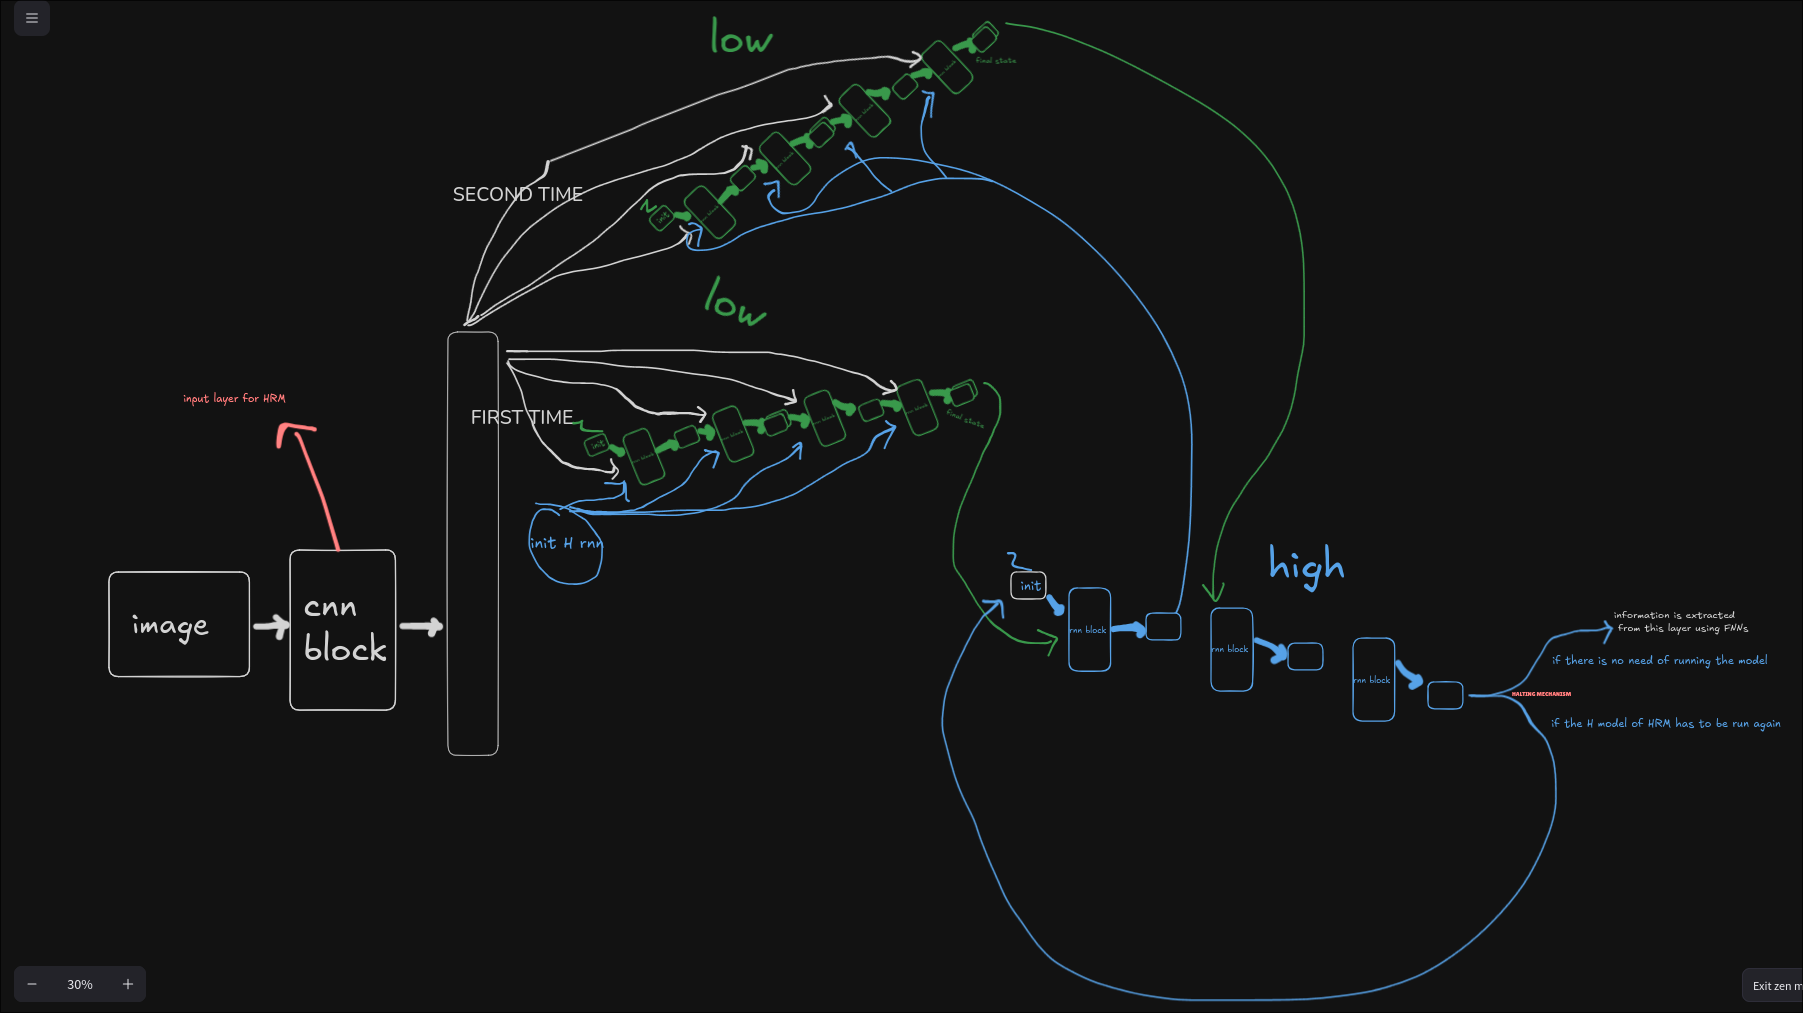

In [ ]:
class HighBlock(nn.Module):
    '''
    High level CEO planner; slow
    '''
    def __init__(self):
        super(HighBlock, self).__init__()
        self.lstm_input_size = 512
        self.lstm_hidden_size = 512

        self.lstm = nn.LSTM(self.lstm_input_size, self.lstm_hidden_size, batch_first=True)

    def forward(self, out):
        out, _ = self.lstm(out) 
        return out

class LowBlock(nn.Module):
    '''
    Low level worker; super fast
    '''
    def __init__(self):
        super(LowBlock, self).__init__()
        self.lstm_input_size = 512
        self.lstm_hidden_size = 512

        self.lstm = nn.LSTM(self.lstm_input_size, self.lstm_hidden_size, batch_first=True)

    def forward(self, out):
        out, _ = self.lstm(out) 
        return out

class HRM(nn.Module):
    '''
    The architecture
    '''
    def __init__(self):
        super(HRM, self).__init__()

        # cnn
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, 3)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3)
        self.bn6 = nn.BatchNorm2d(128)

        self.pool1 = nn.MaxPool2d(2, 2, padding=1) 
        self.pool2 = nn.MaxPool2d(2, 2, padding=1) 
        self.pool3 = nn.MaxPool2d(2, 2, padding=1) 
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        
        # lstm
        self.L = LowBlock()
        self.H = HighBlock()

        # ffnn
        self.fc1 = nn.Linear(512, 2048)
        self.fc2 = nn.Linear(2048, 10)

    def forward(self, x):
        _bs = x.size(0)
        out = F.elu(self.bn1(self.conv1(x)))
        out = F.elu(self.bn2(self.conv2(out)))
        out = self.pool1(out)
        out = self.dropout1(out)
        out = F.elu(self.bn3(self.conv3(out)))
        out = F.elu(self.bn4(self.conv4(out)))
        out = self.pool2(out)
        out = self.dropout2(out)
        out = F.elu(self.bn5(self.conv5(out)))
        out = F.elu(self.bn6(self.conv6(out)))
        out = self.pool3(out)
        out = out.view(_bs, 1, -1)  # Reshape for LSTM: (batch, seq_len=1, features)
        
        # the running of H and L comes here
        for _ in range(3): # implement the halting mech here
            # print(out.shape)
            out = self.L(out)
            # print(out.shape)
            out = self.H(out)

            
        out = self.dropout3(out)
        out = F.elu(self.bn_fc1(self.fc1(out[:, -1, :])))  # Use last (and only) timestep
        out = self.fc2(out)
        return out   


In [ ]:
model = HRM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# model = torch.compile(model)

In [ ]:
# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
epochs_recorded = []

In [ ]:
# Training
for epoch in range(50):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct_train / total_train
    print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

    # Evaluation every 5 epochs
    if (epoch+1) % 5 == 0 and epoch > 1:
        model.eval()

        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(testloader)
        test_acc = 100 * correct / total
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
        
        # Store metrics
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch + 1)

In [ ]:
# Plot graphs
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_recorded, train_losses, 'b-', marker='o', label='Train')
plt.plot(epochs_recorded, test_losses, 'r-', marker='s', label='Test')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Combined accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_recorded, train_accuracies, 'g-', marker='o', label='Train')
plt.plot(epochs_recorded, test_accuracies, 'r-', marker='s', label='Test')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()